In [3]:
! pip install scikit-plot

In [0]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import shutil

try:
    shutil.rmtree("fer13")
except Exception:
    pass

In [7]:
from zipfile import ZipFile 

file_name = "drive/My Drive/FER/datasets/final_u1.zip"
  
with ZipFile(file_name, 'r') as zip_:
    print('Extracting all the files...') 
    zip_.extractall("fer13")
    print('Done!')

Extracting all the files...
Done!


In [8]:
import os
import cv2
import dlib
import math
import numpy as np

from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog

import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from keras import backend as K
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [0]:
np.random.seed(42)

In [0]:
DATA = "fer13"
DATA_PATH = "fer13/final/"
BASE_PATH = "drive/My Drive/FER/Colab/GauravSharma/Multi-Input-Model/"

In [11]:
class_count = {}
for dir_ in os.listdir(DATA_PATH):
    if not dir_.isupper():
        os.rename(DATA_PATH+dir_, DATA_PATH+dir_.title())
        dir_ = dir_.title()

    count = 0
    for f in os.listdir(DATA_PATH + dir_ + "/"):
        count += 1

    class_count[dir_] = count
    print(f"{dir_} has {count} number of images")

total_images = sum(class_count.values())
print(f"\ntotal images are {total_images}")

Neutral has 1446 number of images
Fear has 859 number of images
Happy has 2477 number of images
Sadness has 1326 number of images
Angry has 966 number of images

total images are 7074


In [12]:
TOP_EMOTIONS = ["Happy", "Neutral", "Sadness"]

for k,v in class_count.items():
    if not k in TOP_EMOTIONS:
        total_images -= v

total_images

5249

In [13]:
%%time

print("Extracting facial ROI, this may take some time")

face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor(BASE_PATH+"dumps/shape_predictor_68_face_landmarks.dat")

ROI_shape = (50,25)
ROI_1 = list(set(range(17,48)) - set(range(29,36)))
ROI_2 = list(range(48,68)) + [33, 4, 14]
roi1_arr = []
roi2_arr = []

inconsistent_images = []
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        print(f"processing {dir_} images...")

        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img = cv2.imread(DATA_PATH + dir_ + "/" + f, 0)
            img_ = cv2.resize(img, (96,96))

            faces = face_detector(img_)
            
            if faces:
                for face in faces:
                    ROI1_landmarks = []
                    ROI2_landmarks = []
                    landmarks = shape_predictor(img_, face)
                    for i in range(0, 68):
                        x = landmarks.part(i).x
                        y = landmarks.part(i).y
                        if i in ROI_1:
                            ROI1_landmarks.append((x,y))
                        if i in ROI_2:
                            ROI2_landmarks.append((x,y))

                    try:
                        (x, y, w, h) = cv2.boundingRect(np.array(ROI1_landmarks))
                        roi1 = img_[y:y+h, x:x+w]
                        roi1 = cv2.resize(roi1, ROI_shape, interpolation=cv2.INTER_CUBIC)
                    except Exception:
                        inconsistent_images.append(dir_ + "/" + f)
                        break

                    try:
                        (x, y, w, h) = cv2.boundingRect(np.array(ROI2_landmarks))
                        roi2 = img_[y:y+h, x:x+w]
                        roi2 = cv2.resize(roi2, ROI_shape, interpolation=cv2.INTER_CUBIC)
                    except Exception:
                        inconsistent_images.append(dir_ + "/" + f)
                        break

                    roi1_arr.append(np.expand_dims(roi1, axis=2))
                    roi2_arr.append(np.expand_dims(roi2, axis=2))
            else:
                inconsistent_images.append(dir_ + "/" + f)

print(f"\ntotal inconsistent images: {len(inconsistent_images)},\t fractions: {len(inconsistent_images) / total_images}")

roi1_arr = np.array(roi1_arr)
print("ROI1", roi1_arr.shape)

roi2_arr = np.array(roi2_arr)
print("ROI2", roi2_arr.shape)

print("\n")

Extracting facial ROI, this may take some time
processing Neutral images...
processing Happy images...
processing Sadness images...

total inconsistent images: 1012,	 fractions: 0.19279862831015432
ROI1 (4237, 25, 50, 1)
ROI2 (4237, 25, 50, 1)


CPU times: user 14.3 s, sys: 394 ms, total: 14.7 s
Wall time: 18.9 s


In [14]:
total_images -= len(inconsistent_images)
total_images

4237

In [15]:
%%time
img_arr = np.empty(shape=(total_images,48,48,1))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
label = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            if not dir_ + "/" + f in inconsistent_images:
                img_arr[i] = np.expand_dims(cv2.imread(DATA_PATH + dir_ + "/" + f, 0), axis=2)
                img_label[i] = label
                i += 1
        print(f"loaded {dir_} images to numpy arrays")
        label_to_text[label] = dir_
        label += 1

img_label = np_utils.to_categorical(img_label)

print(img_arr.shape, img_label.shape)

print("\n")

loaded Neutral images to numpy arrays
loaded Happy images to numpy arrays
loaded Sadness images to numpy arrays
(4237, 48, 48, 1) (4237, 3)


CPU times: user 279 ms, sys: 91.1 ms, total: 370 ms
Wall time: 370 ms


In [16]:
label_to_text

{0: 'Neutral', 1: 'Happy', 2: 'Sadness'}

In [17]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'Happy': 1, 'Neutral': 0, 'Sadness': 2}

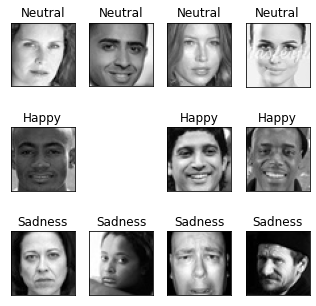

In [18]:
num_emotions = len(TOP_EMOTIONS)
fig = pyplot.figure(1, (num_emotions*1.5, num_emotions*1.5))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:,k]==1)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(num_emotions,4,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

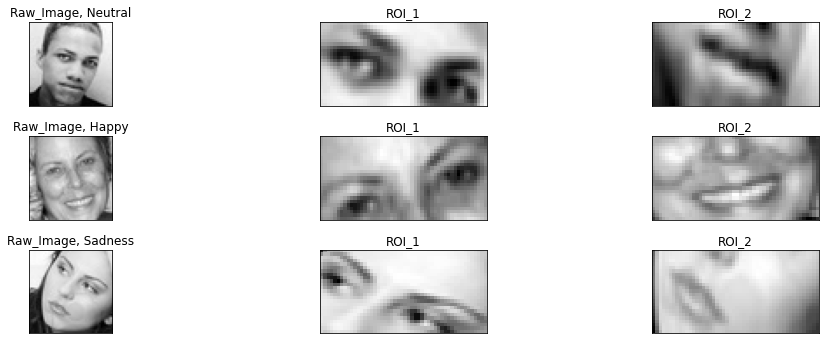

In [19]:
fig = pyplot.figure(1, (14,8))

np.random.seed(10)
idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:,k]==1)[0], size=1, replace=False)
    sample_images = img_arr[sample_indices]
    sample_roi1 = roi1_arr[sample_indices]
    sample_roi2 = roi2_arr[sample_indices]

    for img,roi1,roi2 in zip(sample_images, sample_roi1, sample_roi2):
        idx += 1
        ax = pyplot.subplot(5,3,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Raw_Image, {label_to_text[k]}")

        idx += 1
        ax = pyplot.subplot(5,3,idx)
        ax.imshow(roi1.reshape(ROI_shape[::-1]), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("ROI_1")

        idx += 1
        ax = pyplot.subplot(5,3,idx)
        ax.imshow(roi2.reshape(ROI_shape[::-1]), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("ROI_2")

        pyplot.tight_layout()

In [0]:
def get_hog_features(img):
    img_ = img.astype("uint8")
    img_ = cv2.resize(img_, (64,128))
    hog = cv2.HOGDescriptor()
    hog_descr = hog.compute(img_)
    return hog_descr

In [21]:
hogfeat_img = []
hogfeat_roi1 = []
hogfeat_roi2 = []

for img,roi1,roi2 in zip(img_arr, roi1_arr, roi2_arr):
    hogfeat_img.append(get_hog_features(img))
    hogfeat_roi1.append(get_hog_features(roi1))
    hogfeat_roi2.append(get_hog_features(roi2))

hogfeat_img = np.array(hogfeat_img)
print(hogfeat_img.shape)

hogfeat_roi1 = np.array(hogfeat_roi1)
print(hogfeat_roi1.shape)

hogfeat_roi2 = np.array(hogfeat_roi2)
print(hogfeat_roi2.shape)

(4237, 3780, 1)
(4237, 3780, 1)
(4237, 3780, 1)


In [0]:
img_arr = img_arr / 255.

In [23]:
Xtrain_roi1, Xtest_roi1, Xtrain_roi2, Xtest_roi2, y_train, y_test = train_test_split(roi1_arr, roi2_arr, img_label,
                                                                                     shuffle=True, stratify=img_label, train_size=0.75, random_state=42)

print(Xtrain_roi1.shape, Xtrain_roi2.shape, y_train.shape)
print(Xtest_roi1.shape, Xtest_roi2.shape, y_test.shape)

ValueError: ignored

In [0]:
def roi1_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_ROI1")
    
    conv2d_1 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1_roi1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1_roi1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2_roi1'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2_roi1')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1_roi1')(batchnorm_2)
    dropout_1 = Dropout(0.35, name='dropout_1_roi1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3_roi1'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3_roi1')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4_roi1'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4_roi1')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2_roi1')(batchnorm_4)
    dropout_2 = Dropout(0.35, name='dropout_2_roi1')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5_roi1'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5_roi1')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6_roi1'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6_roi1')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3_roi1')(batchnorm_6)
    dropout_3 = Dropout(0.5, name='dropout_3_roi1')(maxpool2d_3)

    flatten = Flatten(name='flatten_roi1')(dropout_3)
    
    dense_1 = Dense(
        256,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1_roi1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7_roi1')(dense_1)
    
    model_out = Dropout(0.45, name='dropout_5_roi1')(batchnorm_7)
    
    return model_in, model_out

In [0]:
def roi2_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_ROI2")
    
    conv2d_1 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1_roi2'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1_roi2')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2_roi2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2_roi2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1_roi2')(batchnorm_2)
    dropout_1 = Dropout(0.35, name='dropout_1_roi2')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3_roi2'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3_roi2')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4_roi2'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4_roi2')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2_roi2')(batchnorm_4)
    dropout_2 = Dropout(0.35, name='dropout_2_roi2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5_roi2'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5_roi2')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6_roi2'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6_roi2')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3_roi2')(batchnorm_6)
    dropout_3 = Dropout(0.5, name='dropout_3_roi2')(maxpool2d_3)

    flatten = Flatten(name='flatten_roi2')(dropout_3)
    
    dense_1 = Dense(
        256,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1_roi2'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7_roi2')(dense_1)
    
    model_out = Dropout(0.45, name='dropout_5_roi2')(batchnorm_7)
    
    return model_in, model_out

In [0]:
def facial_HOGfeat_pipeline(input_shape, postfix):
    model_in = Input(shape=input_shape, name=f"input_HOGfeat_{postfix}")
    flatten = Flatten(name=f"flatten_hogfeat_{postfix}")(model_in)
    dense1 = Dense(512, activation="elu", name=f"dense1_hogfeat_{postfix}")(flatten)
    model_out = Dropout(0.4, name=f"dropout1_hogfeat_{postfix}")(dense1)
    return model_in, model_out

In [0]:
def merge_models(models_in: list, models_out: list, num_classes: int, show_summary=False):
    
    concated = Concatenate()(models_out)
    dropout_1 = Dropout(0.2, name='dropout1_merged')(concated)

    dense1 = Dense(128, activation="elu", name="dense1_merged")(dropout_1)
    dropout_2 = Dropout(0.4, name='dropout2_merged')(dense1)

    dense2 = Dense(64, activation="elu", name="dense2_merged")(dropout_2)
    dropout_3 = Dropout(0.3, name='dropout3_merged')(dense2)

    out = Dense(num_classes, activation="softmax", name="out_layer")(dropout_3)

    model = Model(inputs=models_in, outputs=out, name="Multi_Input_Model")

    if show_summary:
        model.summary()
    
    return model

In [0]:
roi1_in, roi1_out = roi1_pipeline(input_shape=(*ROI_shape[::-1],1))
roi2_in, roi2_out = roi2_pipeline(input_shape=(*ROI_shape[::-1],1))

num_classes = y_train.shape[1]

model = merge_models(
    models_in=[roi1_in, roi2_in, ],
    models_out=[roi1_out, roi2_out, ],
    num_classes=num_classes,
)

model_name = "roi1+roi2"
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True,
           dpi=50,)# to_file=BASE_PATH+f'architectures/{model_name}_model_{DATA}.png')

In [0]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00001,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.00008,
    factor=0.25,
    patience=4,
    min_lr=1e-6,
    verbose=1,
)

callbacks = [
    # early_stopping,
    lr_scheduler,
]

In [0]:
batch_size = 16
epochs = 60
lr = 0.001
optim = optimizers.Adam(learning_rate=lr)

model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

history = model.fit(
    x = [Xtrain_roi1, Xtrain_roi2],
    y = y_train,
    validation_data=([Xtest_roi1, Xtest_roi2,], y_test),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

In [0]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

# pyplot.savefig(BASE_PATH + f'epoch_metrics/{model_name}_{num_classes}emo_{DATA}.png')
pyplot.show()

In [0]:
label_to_text, text_to_label

In [0]:
yhat_test = model.predict([Xtest_roi1, Xtest_roi2])
yhat_test = np.argmax(yhat_test, axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
# pyplot.savefig(BASE_PATH + f'confusion_matrix/{model_name}_{num_classes}emo_{DATA}.png')

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

### Visualizing the Model

In [0]:
sns.reset_orig()

images = [Xtest_roi1[0], Xtest_roi2[0]]

pyplot.figure(1, (16,4))
for idx,img in enumerate(images):
    ax = pyplot.subplot(1,3,idx+1)
    ax.imshow(img.reshape(25,50), cmap="viridis")
    pyplot.tight_layout()

In [0]:
images_ = [np.expand_dims(img, axis=0) for img in images]
images_[0].shape

In [0]:
layer_list = [(layer.name, layer) for layer in model.layers if "conv" in layer.name]
layer_list

In [0]:
%%time

INTERESTED_CONV_LAYERS = [f"conv2d_{i}_roi1" for i in range(1,5)]

i = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:
        model_conv2d = Model(inputs=model.inputs, outputs=layer[1].output)
        featuremaps_conv2d = model_conv2d.predict(images_)

        cols = 10
        rows = math.ceil(featuremaps_conv2d.shape[-1] / cols)

        fig = pyplot.figure(i, (20, rows))
        i += 1
        
        for idx, feature_map in enumerate(np.rollaxis(featuremaps_conv2d, axis=3)):
            ax = pyplot.subplot(rows, cols ,idx+1)
            ax.imshow(feature_map[0], cmap="viridis")
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.suptitle(f"layer name: {layer[0]}, feature map shape: {featuremaps_conv2d.shape}", fontsize=20, y=1.1)
            pyplot.tight_layout()

In [0]:
%%time

INTERESTED_CONV_LAYERS = [f"conv2d_{i}_roi2" for i in range(1,5)]

i = 1
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:
        model_conv2d = Model(inputs=model.inputs, outputs=layer[1].output)
        featuremaps_conv2d = model_conv2d.predict(images_)

        cols = 10
        rows = math.ceil(featuremaps_conv2d.shape[-1] / cols)

        fig = pyplot.figure(i, (20, rows))
        i += 1
        
        for idx, feature_map in enumerate(np.rollaxis(featuremaps_conv2d, axis=3)):
            ax = pyplot.subplot(rows, cols ,idx+1)
            ax.imshow(feature_map[0], cmap="viridis")
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.suptitle(f"layer name: {layer[0]}, feature map shape: {featuremaps_conv2d.shape}", fontsize=20, y=1.1)
            pyplot.tight_layout()

In [0]:
preds = model.predict(images_)
label_to_text[np.argmax(preds[0])]

In [0]:
pred_vector_output = model.output[:, np.argmax(preds[0])]
pred_vector_output

In [0]:
INTERESTED_LAYERS = ["conv2d_1_img", "conv2d_1_roi1", "conv2d_1_roi2"]

heatmaps = []
for layer in layer_list:
    if layer[0] in INTERESTED_CONV_LAYERS:
        some_conv_layer = model.get_layer(layer[0])
        grads = K.gradients(pred_vector_output, some_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, some_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([images_])

        for i in range(model.get_layer(layer[0]).output_shape[-1]):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        heatmaps.append(np.mean(conv_layer_output_value, axis=-1))

fig = pyplot.figure(figsize=(14, 3))

for i, (name,hm) in enumerate(zip(INTERESTED_CONV_LAYERS, heatmaps)):
    ax = pyplot.subplot(1, 6, i+1)
    img_heatmap = np.maximum(hm, 0)
    img_heatmap /= np.max(img_heatmap)
    ax.imshow(img_heatmap, cmap="viridis")
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.title(name)
    pyplot.tight_layout()